## Glider interpolation

In [1]:
from scipy.io import loadmat
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import gsw

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/glidertools/mapping.py:1336: GliderToolsWarning: PyKrige is not installed. To enable the variogram function please run `pip install pykrige`. Variograms are required for sensible 2D interpolation.
  warnings.warn(message, category=GliderToolsWarning)


In [4]:
data_659 = '/Users/dhruvbalwada/work_root/sogos/data/interim/gliders/sg659/CTD_659.nc'

In [5]:
ds_659 = xr.load_dataset(data_659)

In [6]:
ds_659

<xarray.Dataset>
Dimensions:      (ctd_data_point: 1363330)
Dimensions without coordinates: ctd_data_point
Data variables:
    pressure     (ctd_data_point) float64 nan nan nan nan ... 1.165 1.037 nan
    latitude     (ctd_data_point) float64 -51.51 -51.51 -51.51 ... -51.7 -51.7
    longitude    (ctd_data_point) float64 30.03 30.03 30.03 ... 38.99 38.99
    temperature  (ctd_data_point) float64 3.564 3.561 3.56 ... 1.812 1.811 1.814
    salinity     (ctd_data_point) float64 nan nan nan nan ... 33.89 33.89 nan
    dives        (ctd_data_point) float64 1.0 1.0 1.0 1.0 ... 462.5 462.5 462.5
    time         (ctd_data_point) datetime64[ns] 2019-04-30T13:20:51.23000345...

In [7]:
days = ds_659.time - np.datetime64('2019-01-01')
days_round_659 = (days / np.timedelta64(1, 'D')).round()

Text(0.5, 1, 'Temp Data 659')

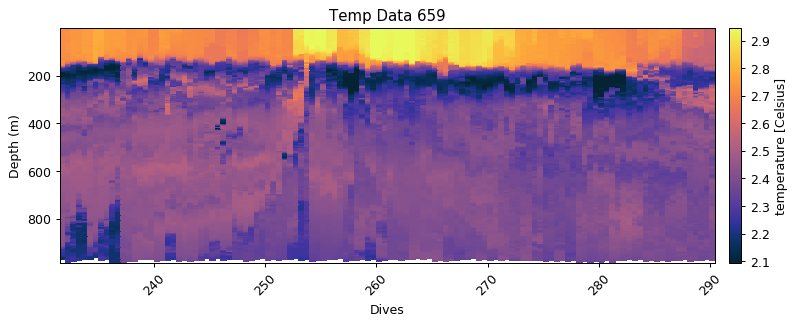

In [8]:
gt.plot(ds_659.dives.where(np.logical_and(days_round_659<170, days_round_659>158), drop=True),
        ds_659.pressure.where(np.logical_and(days_round_659<170, days_round_659>158), drop=True),
        ds_659.temperature.where(np.logical_and(days_round_659<170, days_round_659>158), drop=True),
        cmap=cmo.thermal, robust=True)
plt.title('Temp Data 659')

In [9]:
temp = ds_659.temperature.where(np.logical_and(days_round_659<170, days_round_659>158), drop=True)
temp = ds_659.temperature.where(np.logical_and(days_round_659<170, days_round_659>158), drop=True)

In [101]:
ds_sel = ds_659.where(np.logical_and(days_round_659<162, days_round_659>158), drop=True)
ds_sel = ds_sel.where(np.logical_and(ds_sel.pressure<400, ds_sel.pressure>150), drop=True)

In [102]:
dist = np.r_[gt.utils.distance(ds_sel.longitude, ds_sel.latitude).cumsum()]

In [103]:
ds_sel.longitude.shape

(11688,)

In [104]:
dist[0:10]

array([ 0.        ,  1.40182946,  2.80393922,  4.20548823,  5.60731755,
        7.00914681,  8.41097602,  9.81280518, 11.2163165 , 12.61814556])

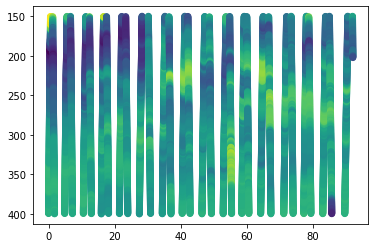

In [105]:
plt.scatter(dist/1e3, ds_sel.pressure, c=ds_sel.temperature)
plt.gca().invert_yaxis()

In [125]:
dist_range = (np.max(dist) - np.min(dist))
pres_range = (np.max(ds_sel.pressure) - np.min(ds_sel.pressure))


npts = len(dist)
x = np.zeros([npts, 3])
x[:,0] = dist/dist_range
x[:,1] = ds_sel.pressure/pres_range
x[:,2] = (ds_sel.time - ds_sel.time[0])/1e9

time_range = (np.max(x[:,2])-np.min(x[:,2]))
x[:,2] = x[:,2]/time_range

# we divided by the range to scale the data

In [126]:
print(np.min(x, axis=0))
print(np.max(x, axis=0))

[0.         0.60018843 0.        ]
[1.         1.60018843 1.        ]


In [127]:
y = ds_sel.temperature.values

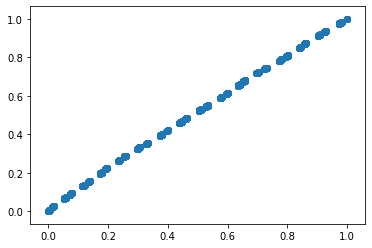

In [128]:
plt.scatter(x[:,0], x[:,2])

In [129]:
import gpytorch
import torch

In [130]:
train_x = torch.from_numpy(x).float()
train_y = torch.from_numpy(y).float()

In [131]:
train_x.shape

torch.Size([11688, 3])

In [153]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP): # setup the class which inherits the ExactGP model
    # initialize the class with X_input, Y_input and a likelihood
    def __init__(self, train_x, train_y, likelihood):
        
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # This calls the __init__ of the inherited class (gpytorch.models.ExactGP),
        # and passes the training data and a likelihood to it.
        # Also ExactGPModel objects have access to 'ExactGP' functions, since it has inherited it.
        
        # Chose a constant mean.
        self.mean_module = gpytorch.means.ConstantMean()
        # ScaleKernel gives the covariance function a scaling factor (K_scale = theta*K_orig)
        self.covar_module = gpytorch.kernels.ScaleKernel(
                            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=3, 
                                                       has_lengthscale=True))#train_x.shape[1])) 
                                        #,lengthscale_prior=[0.5, 0.5, 0.5]))

        # forward takes some x input of size nXd (n-num samples, d-input dim),
        # and returns the multivariate gaussian with mu(x) and cov(x)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [154]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

hypers = {
    'likelihood.noise_covar.noise': torch.tensor(.01),
    'covar_module.base_kernel.lengthscale': torch.tensor([.5, .5, .5]),
    'covar_module.outputscale': torch.tensor(1.),
}
model.initialize(**hypers);

In [156]:
print(model.covar_module.outputscale.item())
print(model.covar_module.base_kernel.lengthscale)

1.0
tensor([[0.5000, 0.5000, 0.5000]], grad_fn=<SoftplusBackward>)


In [157]:
# Find optimal model hyperparameters
model.train() 
likelihood.train();
# these calls set the model and likelihood into training modes 
# (they don't actually train anything)
# Use the adam optimizer
optimizer = torch.optim.Adam([
                {'params': model.parameters()},  # Includes GaussianLikelihood parameters
                              ], lr=0.05) # set learning rate of 0.1

In [158]:

# "Loss" for GPs - the marginal log likelihood log(p(y(x)))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


training_iter = 100 # set as many stels as we want to take 

loss_vals = np.zeros(training_iter)
for i in range(training_iter):
    
        # Zero gradients from previous iteration
    optimizer.zero_grad()

    # Output from model
    output = model(train_x)

    # Calc loss and backprop gradients
    # loss is defined is -log(p(Y(x)))

    # the way the PyTorch optimizer works is that it looks for a variable called loss,
    # which also has a gradient (calc by calling backward), and tries to reduce it.
    loss = -mll(output, train_y)

    loss.backward()
    
    if np.mod(i,2)==0:
        print('Iter %d/%d - Loss: %.3f   lengthscale1: %.3f lengthscale2: %.3f lengthscale3: %.3f  noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale[0][0].item(),
            model.covar_module.base_kernel.lengthscale[0][1].item(),
            model.covar_module.base_kernel.lengthscale[0][2].item(),
            model.likelihood.noise.item()
              ))
    loss_vals[i] = loss.item()
        
    optimizer.step()

Iter 1/100 - Loss: -1.280   lengthscale1: 0.500 lengthscale2: 0.500 lengthscale3: 0.500  noise: 0.010
Iter 3/100 - Loss: -1.332   lengthscale1: 0.462 lengthscale2: 0.462 lengthscale3: 0.462  noise: 0.009
Iter 5/100 - Loss: -1.386   lengthscale1: 0.426 lengthscale2: 0.427 lengthscale3: 0.426  noise: 0.008
Iter 7/100 - Loss: -1.438   lengthscale1: 0.393 lengthscale2: 0.398 lengthscale3: 0.393  noise: 0.007
Iter 9/100 - Loss: -1.484   lengthscale1: 0.364 lengthscale2: 0.377 lengthscale3: 0.364  noise: 0.007
Iter 11/100 - Loss: -1.527   lengthscale1: 0.345 lengthscale2: 0.371 lengthscale3: 0.347  noise: 0.006
Iter 13/100 - Loss: -1.570   lengthscale1: 0.334 lengthscale2: 0.383 lengthscale3: 0.337  noise: 0.006
Iter 15/100 - Loss: -1.616   lengthscale1: 0.326 lengthscale2: 0.403 lengthscale3: 0.335  noise: 0.005
Iter 17/100 - Loss: -1.663   lengthscale1: 0.322 lengthscale2: 0.430 lengthscale3: 0.336  noise: 0.005
Iter 19/100 - Loss: -1.713   lengthscale1: 0.322 lengthscale2: 0.459 lengthsca

KeyboardInterrupt: 

In [ ]:
lengthscale1: 0.192 lengthscale2: 0.304 lengthscale3: 0.219  noise: 0.001

In [141]:
print(.192*dist_range/1e3)
print(.304*pres_range.values)
print(.219*time_range/24/3600)

17.701341662514977
75.98168007564124
0.6456267013888889


In [152]:
print(.561*dist_range/1e3)
print(2.761*pres_range.values)
print(.726*time_range/24/3600)

51.72110767016095
690.0836141080443
2.1402967361111114


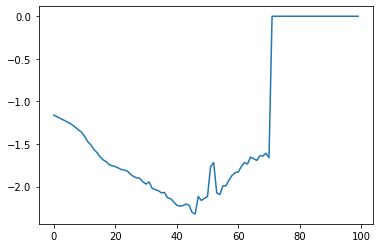

In [144]:
plt.plot(loss_vals)

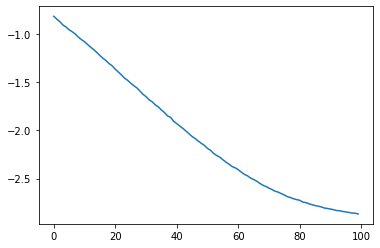

In [151]:
plt.plot(loss_vals)

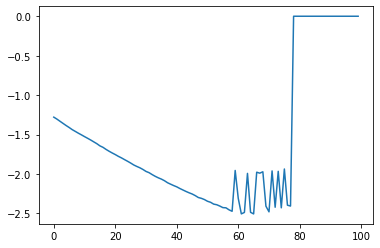

In [159]:
plt.plot(loss_vals)

### Using GPUs

In [160]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

hypers = {
    'likelihood.noise_covar.noise': torch.tensor(.01),
    'covar_module.base_kernel.lengthscale': torch.tensor([.5, .5, .5]),
    'covar_module.outputscale': torch.tensor(1.),
}
model.initialize(**hypers);

In [161]:
train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

AssertionError: Torch not compiled with CUDA enabled

In [163]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [164]:
train_x = torch.linspace(0, 10, 10000)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)


In [165]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [166]:
%%time 
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.054   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.963   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.845   lengthscale: 0.599   noise: 0.599
Iter 4/50 - Loss: 0.742   lengthscale: 0.556   noise: 0.555
Iter 5/50 - Loss: 0.669   lengthscale: 0.516   noise: 0.514
Iter 6/50 - Loss: 0.616   lengthscale: 0.480   noise: 0.475
Iter 7/50 - Loss: 0.572   lengthscale: 0.450   noise: 0.438
Iter 8/50 - Loss: 0.531   lengthscale: 0.424   noise: 0.403
Iter 9/50 - Loss: 0.491   lengthscale: 0.402   noise: 0.370
Iter 10/50 - Loss: 0.452   lengthscale: 0.382   noise: 0.340
Iter 11/50 - Loss: 0.413   lengthscale: 0.366   noise: 0.311
Iter 12/50 - Loss: 0.374   lengthscale: 0.351   noise: 0.285
Iter 13/50 - Loss: 0.337   lengthscale: 0.339   noise: 0.261
Iter 14/50 - Loss: 0.299   lengthscale: 0.328   noise: 0.238
Iter 15/50 - Loss: 0.260   lengthscale: 0.318   noise: 0.217
Iter 16/50 - Loss: 0.223   lengthscale: 0.309   noise: 0.198
Iter 17/50 - Loss: 0.188   length